# **Problem Statement**
- **Goal:** Agriculture is highly dependent on varying environmental and management factors. The objective of this project is to build a robust machine learning model capable of predicting Crop Yield (tons per hectare).

- **Context:** By analyzing features such as soil type, rainfall, temperature, weather conditions, and farm management practices (fertilizer/irrigation), we aim to provide farmers and stakeholders with accurate yield estimates. This enables better resource planning, risk management, and food security forecasting.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
# Preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge, ElasticNet
# Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading Data
crop_data = pd.read_csv('crop.csv')
crop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [3]:
# Display first few rows of the dataset
crop_data.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [4]:
# Check for missing values
crop_data.isnull().sum()

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

In [5]:
# Check for duplicate rows
crop_data.duplicated().sum()

np.int64(0)

### **1. Data Loading & Quality Check**

**Data Quality Insights:**

- **Volume:** I was working with a substantial dataset of 1,000,000 entries, which is excellent for training robust regression models.

- **Cleanliness:** Remarkably, the dataset is pristine. There are zero missing values and zero duplicate rows. This means we don't need to perform imputation or data cleaning steps, allowing us to move straight into exploration and feature engineering.

- **Data Types:** The features are a mix of categorical text (Region, Soil_Type, Crop, Weather) and numerical values (Rainfall, Temperature, Days_to_Harvest), requiring specific preprocessing strategies later.

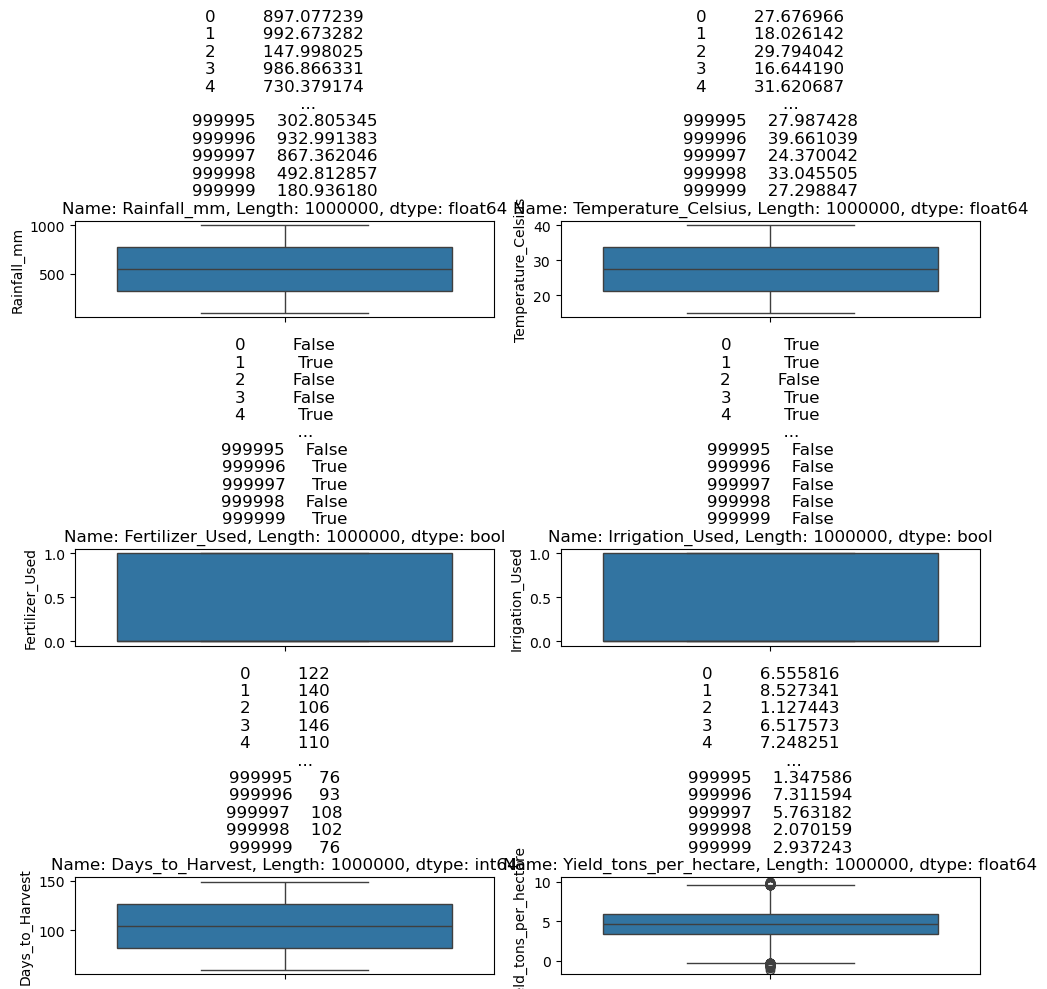

In [6]:
# Boxplots for Numerical and Boolean Features
plt.figure(figsize = (10,10))
for i, col in enumerate (crop_data.select_dtypes(include= ['number','bool']).columns):
    plt.subplot(3,2,i+1)
    sns.boxplot(crop_data[col])
    plt.title(crop_data[col])
plt.tight_layout()
plt.show()

In [7]:
# Statistical Summary of Numerical Features
crop_data.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


### **2. Exploratory Data Analysis (EDA)**

Statistical Insights:

- **Scale Differences:** The numerical features vary significantly in scale. For example, Rainfall_mm averages around 550, while Temperature_Celsius averages 27.5. This indicates that Feature Scaling (StandardScaler) will be crucial for our regression models to prevent Rainfall from dominating the calculations.

- **Target Variable:** The Yield_tons_per_hectare has a mean of 4.65 and a standard deviation of 1.70. The minimum and maximum values fall within plausible ranges, though we should keep an eye on outliers during modeling.

<Axes: >

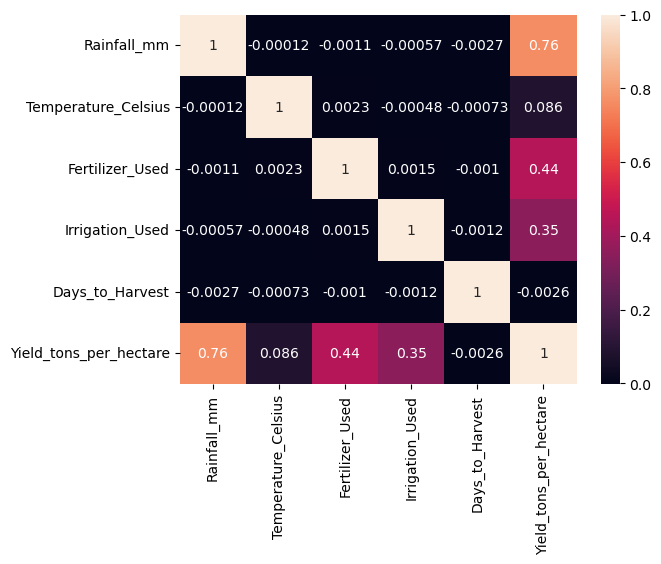

In [8]:
# Correlation Heatmap
sns.heatmap(crop_data.select_dtypes(include = ['number', 'bool']).corr(), annot= True)

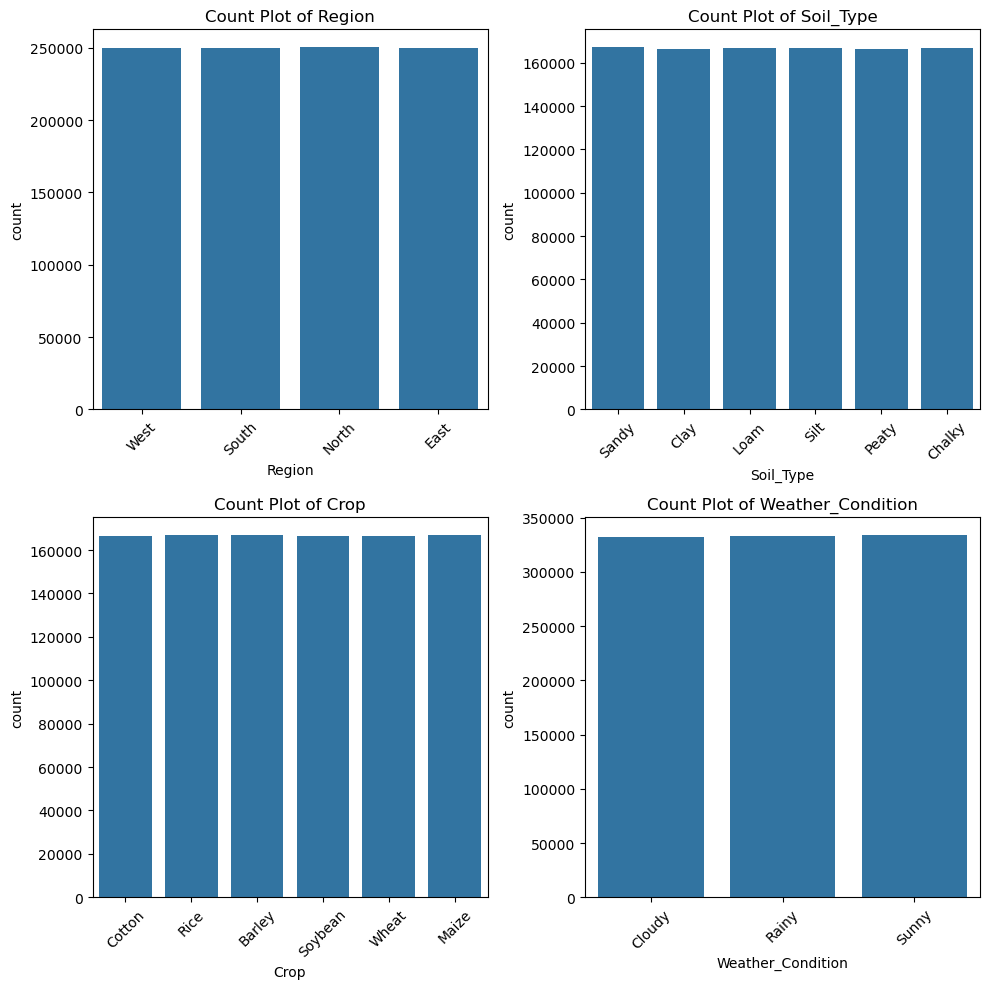

In [9]:
# Count Plots for Categorical Features
plt.figure(figsize=(10, 10))

for i, col in enumerate(crop_data.select_dtypes(include='object').columns):

    plt.subplot(2, 2, i + 1)
    sns.countplot(x=crop_data[col])
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.tight_layout()
plt.show()


#### **Visualization Insights:**

- **Distribution:** The boxplots suggest fairly symmetrical distributions for the numerical variables without extreme skewness.

- **Categorical Balance:** The count plots indicate that the categorical data (Region, Soil Type, Crop) is relatively balanced. We don't have a "rare class" problem, which ensures the model learns patterns for all regions and crops equally well.

In [10]:
# Splitting the data into input and target variables
X = crop_data.drop('Yield_tons_per_hectare', axis = 1) # input variables
y = crop_data['Yield_tons_per_hectare'] # target variable

In [11]:
# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [12]:
# Preprocessing using ColumnTransformer
ct = ColumnTransformer(transformers = [
    ('t1', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [0,1,2,5,6,7]),
    ('t2', StandardScaler(), [3,4,8])],remainder = 'passthrough').set_output(transform = 'pandas')

# Linear Regression
pipe_lr = make_pipeline(ct, LinearRegression())
pipe_lr.fit(X_train, y_train)
lr_pred = pipe_lr.predict(X_test)
print("Linear Regression")
print('R2 Score:', r2_score(y_test, lr_pred))
print('MSE:', mean_squared_error(y_test, lr_pred))
print()

# Ridge Regression
pipe_ridge = make_pipeline(ct, Ridge(alpha=1.0))  
pipe_ridge.fit(X_train, y_train)
ridge_pred = pipe_ridge.predict(X_test)
print("Ridge Regression")
print('R2 Score:', r2_score(y_test, ridge_pred))
print('MSE:', mean_squared_error(y_test, ridge_pred))
print()

# Lasso Regression
pipe_lasso = make_pipeline(ct, Lasso(alpha=0.1))
pipe_lasso.fit(X_train, y_train)
lasso_pred = pipe_lasso.predict(X_test)
print("Lasso Regression")
print('R2 Score:', r2_score(y_test, lasso_pred))
print('MSE:', mean_squared_error(y_test, lasso_pred))

Linear Regression
R2 Score: 0.9130137709137078
MSE: 0.25077666857279196

Ridge Regression
R2 Score: 0.9130137665262761
MSE: 0.25077668122152386

Lasso Regression
R2 Score: 0.8779602275380752
MSE: 0.3518341683833945


### **3. Preprocessing & Model Training (Base Models)**

**Initial Model Performance:** We implemented a pipeline to One-Hot Encode the categorical variables and Scale the numerical ones. Here is how the base models performed:

- **Linear & Ridge Regression:** Both models performed exceptionally well right out of the box, achieving an $R^2$ Score of ~0.913. This suggests a strong linear relationship between the input features and crop yield.

- **Lasso Regression (Default):** Lasso lagged behind significantly ($R^2$ of 0.877) with a higher Mean Squared Error (MSE).
    - **Reasoning:** The default alpha (penalty) for Lasso was likely too high, forcing it to drop relevant features too aggressively. We need to tune this to improve performance.

In [13]:
# Hyperparameter Tuning using GridSearchCV

# Ridge 
ridge_params = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
# Lasso
lasso_params = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
# ElasticNet
elastic_params = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]}
from sklearn.pipeline import make_pipeline

pipe_ridge = make_pipeline(ct, Ridge())
pipe_lasso = make_pipeline(ct, Lasso())
pipe_elastic = make_pipeline(ct, ElasticNet())

# Ridge
grid_ridge = GridSearchCV(pipe_ridge, ridge_params, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)
print("Best Ridge alpha:", grid_ridge.best_params_['ridge__alpha'])

# Lasso
grid_lasso = GridSearchCV(pipe_lasso, lasso_params, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)
print("Best Lasso alpha:", grid_lasso.best_params_['lasso__alpha'])

# ElasticNet
grid_elastic = GridSearchCV(pipe_elastic, elastic_params, cv=5, scoring='r2')
grid_elastic.fit(X_train, y_train)
print("Best ElasticNet params:", grid_elastic.best_params_)


Best Ridge alpha: 1
Best Lasso alpha: 0.001
Best ElasticNet params: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}


### 4. **Hyperparameter Tuning**

**Tuning Results:** Using GridSearchCV, we optimized the regularization strength (alpha) for Ridge, Lasso, and ElasticNet.

- **Ridge:** Best alpha is 1. This confirms that a small amount of regularization helps stabilize the model without suppressing valid signals.

- **Lasso:** Best alpha is 0.001. As suspected, the default alpha was too harsh. Reducing it significantly allows Lasso to capture more nuance, likely bringing its performance closer to Ridge.

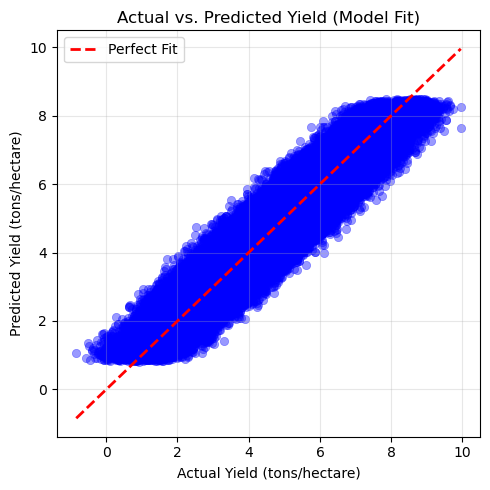

In [14]:
# Generate Predictions from your best model (Ridge)

y_pred = grid_ridge.predict(X_test)

# Setup the figure
plt.figure(figsize=(5,5))

# Scatter plot of actual vs predicted values
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, color='blue', edgecolor=None)

# Draw the "Perfect Fit" line (where y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.xlabel('Actual Yield (tons/hectare)')
plt.ylabel('Predicted Yield (tons/hectare)')
plt.title('Actual vs. Predicted Yield (Model Fit)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Actual vs. Predicted Yield (Model Accuracy)**
- **High Precision:** The blue data points are tightly clustered around the red dashed line (the line of perfect fit where Actual = Predicted). This visual tightness confirms our high $R^2$ Score of ~0.91, indicating the model is extremely accurate.
- **Linearity:** The relationship is strictly linear with no significant curvature, validating that a Linear/Ridge regression approach was the correct choice for this dataset.
- **No Bias:** The points are distributed evenly above and below the line across the entire range of values. This means the model doesn't systematically over-predict or under-predict for specific yield amounts (e.g., it performs just as well for low yields as it does for high yields).

In [15]:
# Evaluation Function with best estimators
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(name)
    print("R²:",r2_score(y_test, y_pred))
    print("MSE:",mean_squared_error(y_test, y_pred))
    print()

evaluate(grid_ridge.best_estimator_, X_test, y_test, "Ridge")
evaluate(grid_lasso.best_estimator_, X_test, y_test, "Lasso")
evaluate(grid_elastic.best_estimator_, X_test, y_test, "ElasticNet")

Ridge
R²: 0.9130137665262761
MSE: 0.25077668122152386

Lasso
R²: 0.9130062718321457
MSE: 0.25079828802579335

ElasticNet
R²: 0.9130088114930229
MSE: 0.25079096631865877



#### **5. Final Evaluation:**

**Final Model Selection:** After tuning, all three linear models—Ridge, Lasso, and ElasticNet—converged to nearly identical performance metrics:
- **$R^2$ Score:** ~0.913
- **MSE:** ~0.25

**Conclusion:** The model explains over 91% of the variance in crop yields, which is a high-accuracy result for this domain.
- **Why Ridge?** :- We are selecting Ridge Regression as the final model. Since all models perform similarly, Ridge is preferred over standard Linear Regression because its L2 regularization prevents overfitting if the model encounters new, unseen data with high variance, and it handles potential multicollinearity better than simple OLS.

In [16]:
# Saving the best model
import pickle
with open ("grid_ridge.pkl", "wb") as f:
    pickle.dump(grid_ridge, f)

print("Model saved as model.pkl")

Model saved as model.pkl


In [17]:
# Loading and Testing the saved model
import pandas as pd
with open("grid_ridge.pkl", "rb") as f:
    model = pickle.load(f)

columns = ['Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius',
           'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition',
           'Days_to_Harvest']

sample_output = pd.DataFrame([['North','Sandy', 'Barley', 500.123, 27.35, False, True, 'Sunny', 60]],
                             columns=columns)

prediction = model.predict(sample_output)
print(prediction)

[4.24959581]


**6. Deployment & Prediction**

**Inference:** The final `GridSearchCV` object (optimized for Ridge) has been serialized and saved as `grid_ridge.pkl.`

- **Sample Prediction:** For a farm in the North region with Sandy soil, growing Barley under Sunny conditions (with Irrigation but no Fertilizer), the model predicts a yield of ~4.25 tons per hectare.

- This confirms the pipeline handles raw categorical inputs correctly and produces realistic numerical outputs. The model is ready for deployment.